**NOTE:**
* Size/volume of tumor linked to survival?
* Sphericity linked to aggressiveness? 

In [1]:
import sys
sys.path.append('./../utils/')

import os
import nrrd
import ioutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [46]:
y_dfs = pd.read_csv('./../../../data_source/to_analysis/target_dfs.csv', index_col=0)
y_lrr = pd.read_csv('./../../../data_source/to_analysis/target_lrr.csv', index_col=0)
"""
NOTE: 

The original DFS data is oriented as DFS(T) = 0, DFS(F) = 1. Reversing for 
the more intuitive interpretaion of target as 

    if occuring: DFS = 1
    if not occuring: DFS = 0

"""
orig_dfs = np.squeeze(y_dfs.values)
y_dfs_reversed = np.copy(orig_dfs)
y_dfs_reversed[orig_dfs == 0] = -2
y_dfs_reversed = y_dfs_reversed  - 1
y_dfs_reversed[orig_dfs == 0] = 1

assert sum(orig_dfs) + sum(y_dfs_reversed) == np.size(y_dfs.values)

outcome_mapping = {
    'no_dfs_lrr': 2,
    'only_dfs': 1,
    'only_lrr': 0
}

target_dummies = np.zeros(np.size(y_dfs), dtype=int)
for num, (dfs, lrr) in enumerate(zip(y_dfs_reversed, y_lrr.values)):
    # Only DFS.
    if dfs == 1 and lrr == 0:
        target_dummies[num] = outcome_mapping['only_dfs']
    # Only LRR.
    elif dfs == 0 and lrr == 1:
        target_dummies[num] = outcome_mapping['only_lrr']
    # Patient experiencing neither of DFS or LRR.
    else: 
        target_dummies[num] = outcome_mapping['no_dfs_lrr']
        
target_dummies

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0,
       1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 2,
       0, 1, 2, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1])

# Oucomes

In [3]:
main_titles = ['Disease-Free Survival', 'Locoregional Relapse']

outcome_ratios = [
    # Not experiencing DFS (but potentially LRR)
    float(y_dfs.sum() / np.size(y_dfs)),
    # Experiencing DFS.
    float(1 - y_dfs.sum()/np.size(y_dfs)),
    float(1 - y_lrr.sum() / np.size(y_lrr)),
    float(y_lrr.sum() / np.size(y_lrr))
]

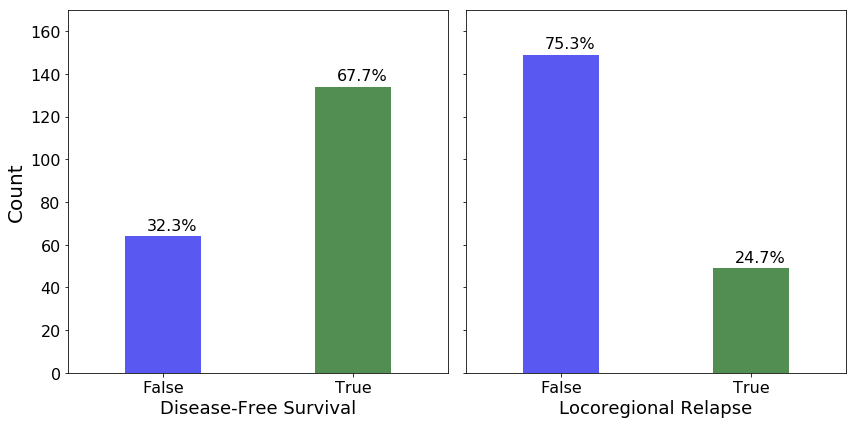

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True, sharex=True);

sns.countplot(
    x=y_dfs_reversed, 
    ax=axes[0], 
    saturation=0.85, 
    palette=['blue', 'darkgreen'], 
    alpha=0.7
)
axes[0].set_ylabel('Count', fontsize=20)
axes[0].set_xticklabels(['True', 'False',])

sns.countplot(
    x='lrr', data=y_lrr, 
    ax=axes[1], 
    saturation=0.85, 
    palette=['blue', 'darkgreen'],
    alpha=0.7,
)
axes[1].set_ylabel('')
axes[1].set_xticklabels(['False', 'True'])

count = 0
for num, axis in enumerate(axes):
    axis.set_xlabel(main_titles[num], fontsize=18)
    axis.tick_params(labelsize=16)
    axis.set_ylim([0, 170])
    for patch in axis.patches:
        current_width = patch.get_width()
        diff = current_width - 0.4
        # Change the bar width,
        patch.set_width(0.4)
        # Recenter the bar,
        patch.set_x(patch.get_x() + diff * 0.5)
        
        axis.annotate(
            '{:.1f}%'.format(outcome_ratios[count] * 100),
            (patch.get_x() + patch.get_width() / 3.5, patch.get_height() + 3), 
            color='k', 
            fontsize=16
        )
        count = count + 1

plt.tight_layout()
plt.savefig(
    './../../../figures/outcome_distr',
    bbox_inches='tight',
    transparent=True,
    dpi=400, 
)

# Clinical Data

In [8]:
clinvar_labels = [
    'Age', 'Sex', 'ICD-10', 'T-stage', 'N-Stage', 'Disease Stage',
    'Histology', 'HPV-status', 'ECOG', 'Charlson Index', 
    'Pack-year', 'Days of Naxogin', 'Cycles of Cisplatin'
]

In [9]:
raw_clinical = pd.read_excel(
    './../../../data_source/tabular/clinical_params.xlsx', index_col=0, header=0
)
raw_clinical.columns = clinvar_labels
raw_clinical.head()

,Age,Sex,ICD-10,T-stage,N-Stage,Disease Stage,Histology,HPV-status,ECOG,Charlson Index,Pack-year,Days of Naxogin,Cycles of Cisplatin
Pasient-ID,,,,,,,,,,,,,
1,57.854795,M,C01,4,2,4a,1.0,2,1,0,32.141096,29.0,0
2,60.832877,M,C09,2,2,4a,0.0,2,0,0,0.000000,39.0,6
3,75.663014,M,C32,2,0,2,1.0,2,0,0,55.663014,41.0,0
4,49.906849,K,C09,2,2,4a,0.0,2,0,0,4.786027,33.0,5
5,54.238356,K,C09,2,0,2,0.0,0,0,0,0.000000,42.0,0


<Figure size 432x288 with 0 Axes>

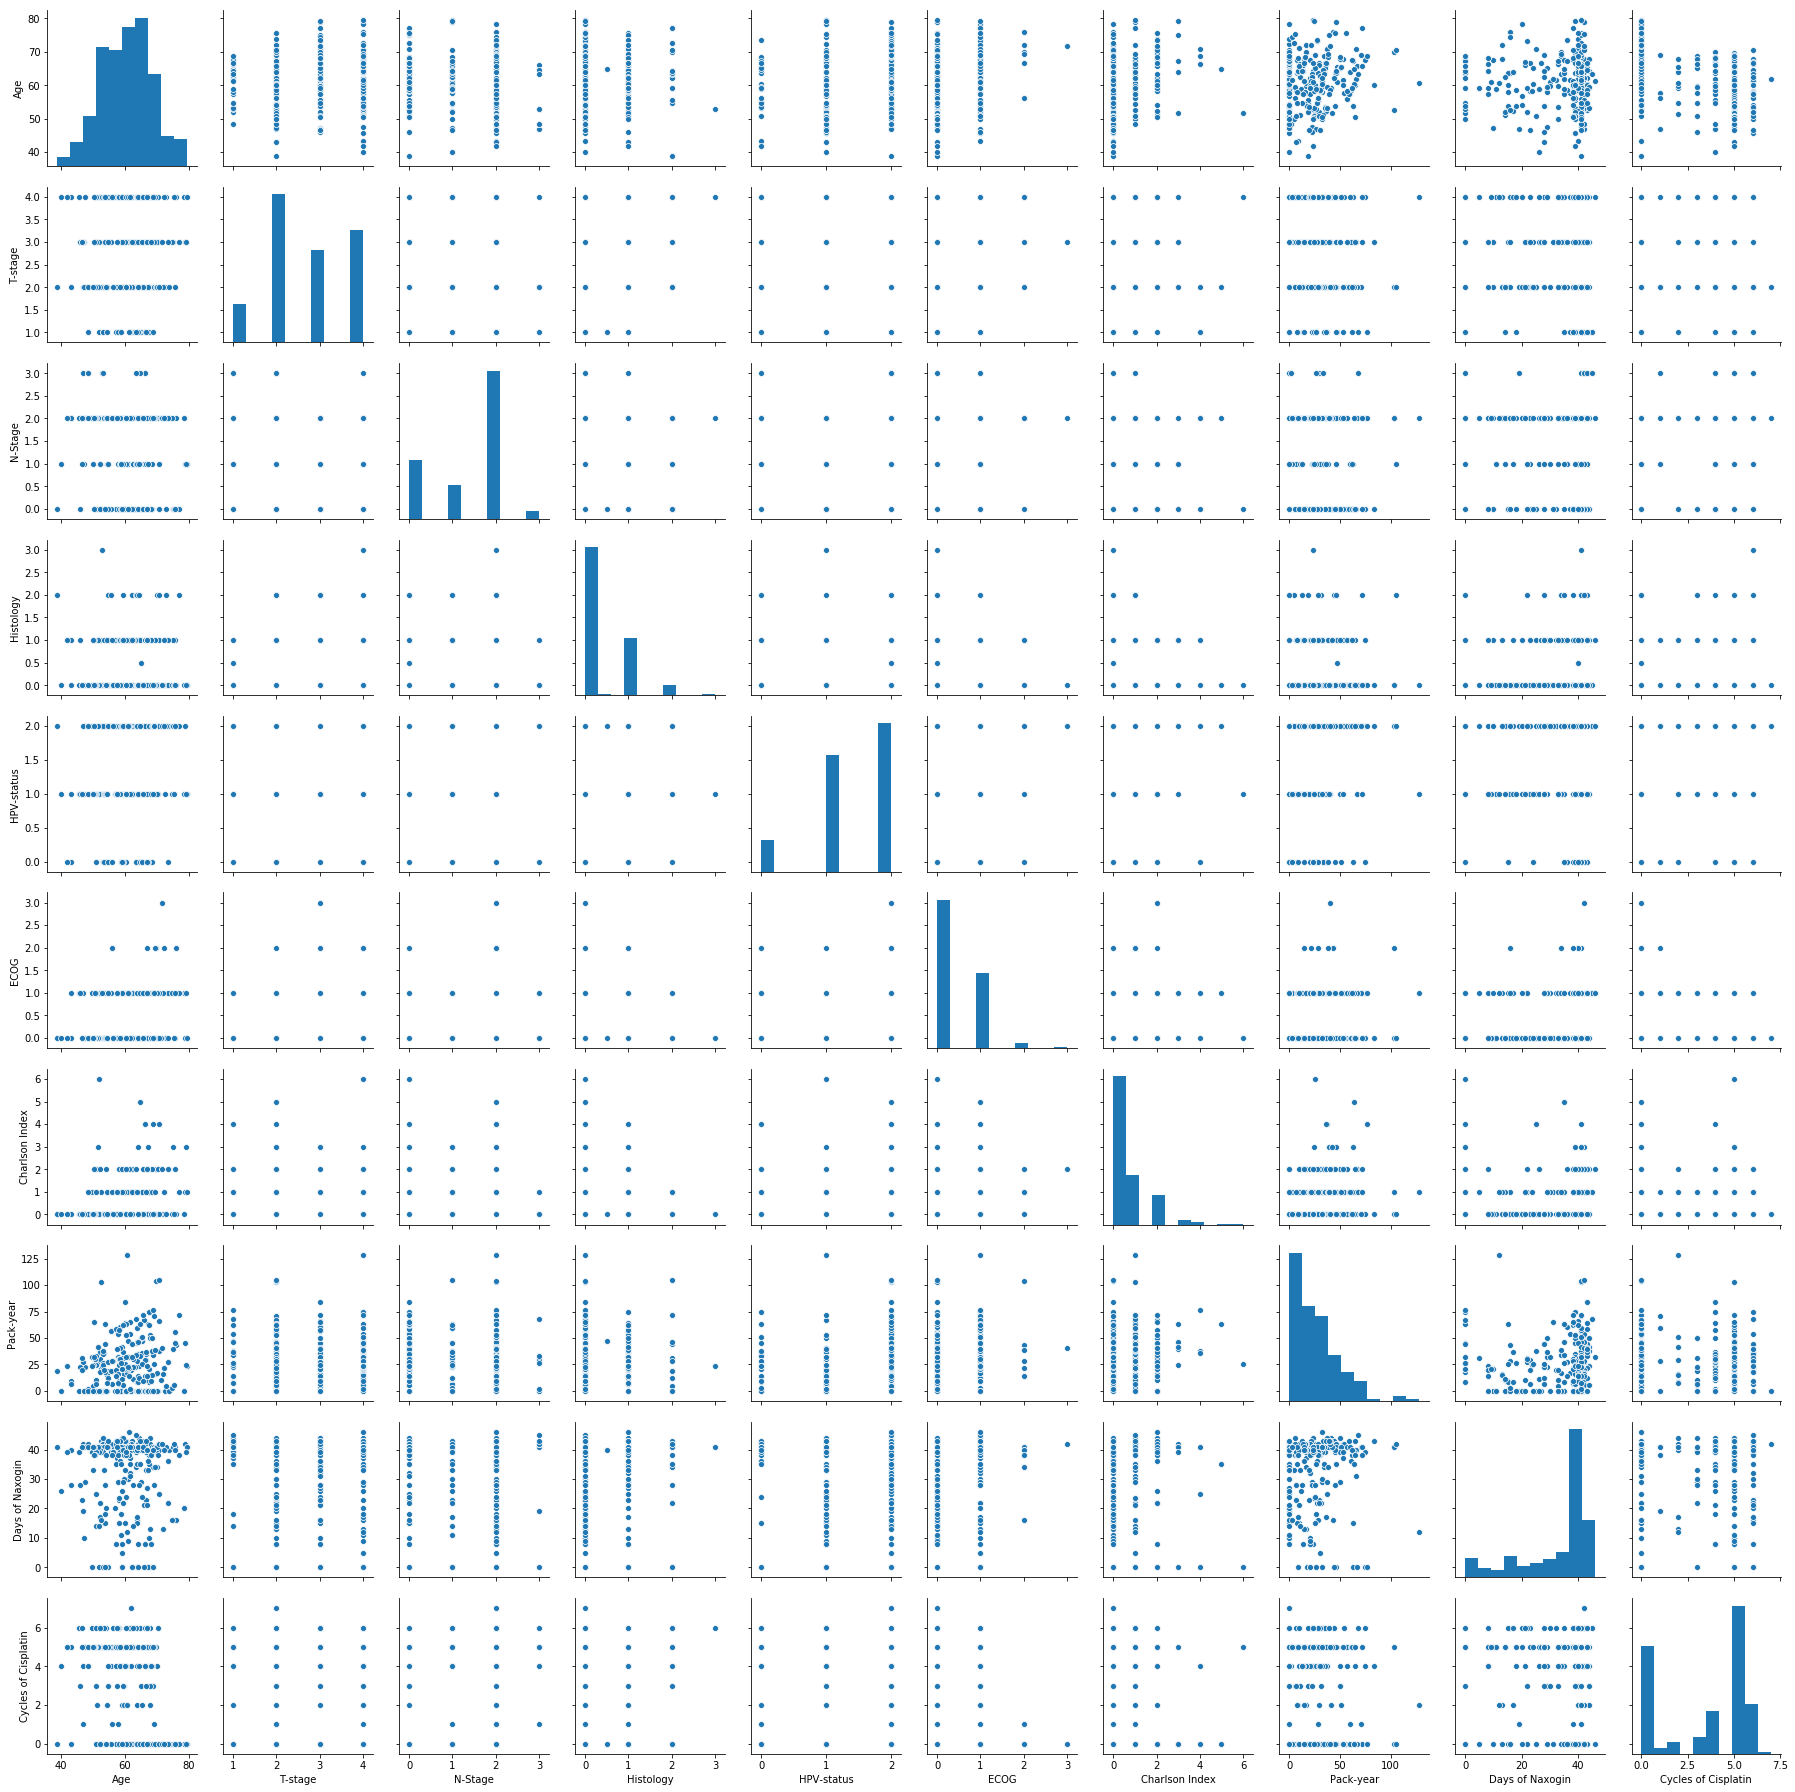

In [10]:
plt.figure()
sns.pairplot(raw_clinical, )#cmap=sns.light_palette((210, 90, 60), input='husl'))

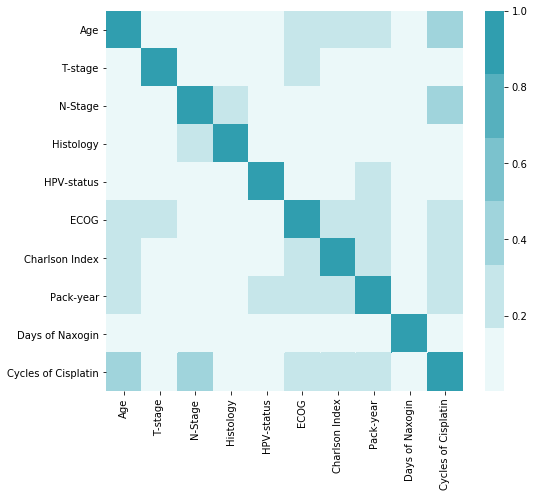

In [11]:
# Create Dcorrelation matrix
corr_matrix = raw_clinical.corr().abs()

plt.figure(figsize=(8, 7))
sns.heatmap(
    corr_matrix,
    cmap=sns.light_palette((210, 90, 60), input='husl')
)
plt.savefig(
    './../../../figures/clinical_corrmat',
    bbox_inches='tight',
    transparent=True,
    dpi=400, 
)

# Tumor Characteristics

In [12]:
shape_stat = pd.read_csv('./../../../data_source/to_analysis/radiomics_shape.csv', index_col=0)
shape_stat.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxis,original_shape_MajorAxis,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MinorAxis,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_Volume
2,0.738882,0.723925,27.060529,37.380273,41.976184,44.598206,42.720019,45.617979,27.619612,0.661532,4860.055715,0.283517,17142.0
4,0.796900,0.629917,19.845151,31.504408,38.587563,35.468296,29.410882,38.704005,25.105855,0.701721,3126.087371,0.323578,9661.0
5,0.600926,0.535140,22.515072,42.073251,46.065171,43.011626,32.015621,46.454279,25.282894,0.762365,4063.633046,0.250625,16214.0
8,0.784571,0.414247,30.263897,73.057649,74.148500,80.956779,65.764732,83.438600,57.318945,0.520001,15698.615155,0.226355,69354.0
10,0.690320,0.539743,19.449801,36.035312,33.286634,38.013156,33.015148,43.150898,24.875896,0.643822,3658.448414,0.340352,10749.0


In [51]:
print(outcome_mapping) 
print(np.unique(target_dummies))

{'no_dfs_lrr': 2, 'only_dfs': 1, 'only_lrr': 0}
[0 1 2]


In [52]:
np.min(shape_stat.filter(regex='shape_Volume').values), np.max(shape_stat.filter(regex='shape_Volume').values)

(798.0, 284957.0)

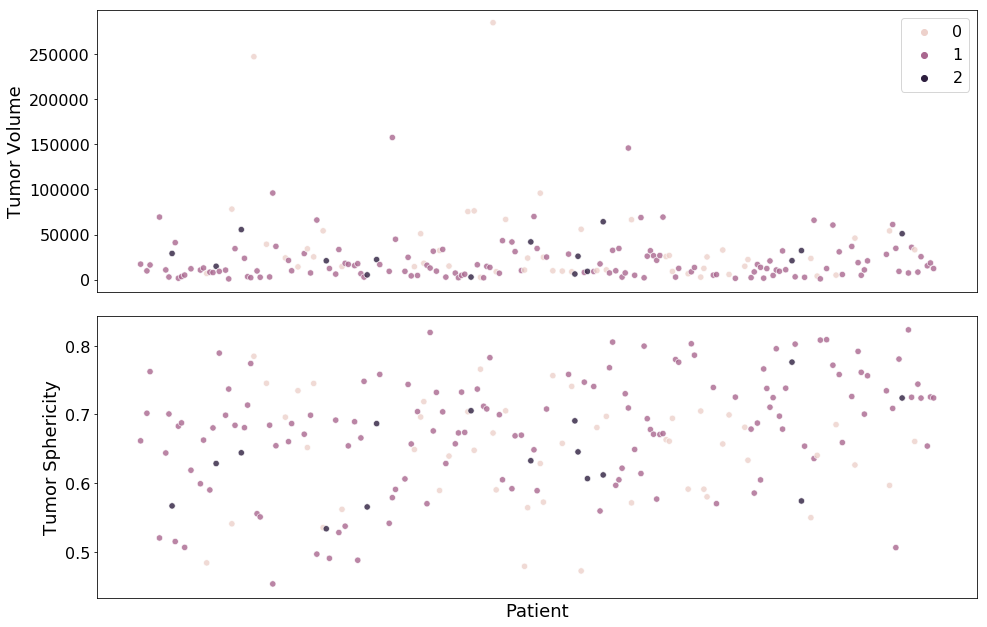

In [76]:
plt.rcParams.update({'font.size': 16}) 
        
palette = ['darkgreen', 'firebrick', 'lightblue']

fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 9))
sns.scatterplot(
    x=np.squeeze(shape_stat.index.values), 
    y=np.squeeze(shape_stat.filter(regex='shape_Volume').values),
    hue=target_dummies,
    #palette=palette,
    alpha=0.8,
    hue_order=[0, 1, 2],
    s=40,
    legend='full',
    ax=axes[0]
)
axes[0].set_ylabel('Tumor Volume', fontsize=18)
"""axes[0].legend(
    ['Only LRR', 'Only DFS', 'Both LRR & DFS', 'Other event'],
    title=r'Outcomes:',
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.05), 
    fancybox=True, shadow=True, 
    ncol=4
)
"""
sns.scatterplot(
    x=np.squeeze(shape_stat.index.values), 
    y=np.squeeze(shape_stat.filter(regex='shape_Sphericity').values),
    hue=target_dummies,
    #palette=palette,
    alpha=0.8,
    s=40,
    legend=False,
    ax=axes[1]
)
axes[1].set_ylabel('Tumor Sphericity', fontsize=18)
#axes[1].legend().set_visible(False)

plt.xlabel('Patient', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.savefig(
    './../../../figures/tumor_character.png',
    bbox_inches='tight',
    transparent=True,
    dpi=400, 
)

**NOTE:**
* Outcomes are either DFS = LRR, or DFS = 1 and LRR = 0. Thus, for no case is LRR = 1 and DFS = 0.

# Raw Image Data

In [135]:
paths_ct = ioutil.relative_paths('./../../../data_source/images/ct_nrrd/', target_format='nrrd')
paths_pet = ioutil.relative_paths('./../../../data_source/images/pet_nrrd/', target_format='nrrd')
paths_masks = ioutil.relative_paths('./../../../data_source/images/masks_nrrd/', target_format='nrrd')

In [136]:
# Statistics on original (not masked) images.
ct_stats, pet_stats = {}, {}
for path_pet, path_ct in zip(paths_pet, paths_ct):
    
    ct_img, _ = nrrd.read(path_ct)
    pet_img, _ = nrrd.read(path_pet)
    
    ct_name = path_ct.split('/')[-1].split('.')[0]
    pet_name = path_pet.split('/')[-1].split('.')[0]
   
    ct_stats[ct_name] = {
        'min': np.min(ct_img),
        'max': np.max(ct_img),
        'mean': np.mean(ct_img),
        'median': np.median(ct_img)
    }
    pet_stats[pet_name] = {
        'min': np.min(pet_img),
        'max': np.max(pet_img),
        'mean': np.mean(pet_img),
        'median': np.median(pet_img)
    }
    
df_ct_stats = pd.DataFrame(ct_stats)
df_pet_stats = pd.DataFrame(pet_stats)

In [137]:
df_ct_stats.head()

,P002CT,P004CT,P005CT,P008CT,P010CT,P011CT,P012CT,P013CT,P014CT,P015CT,...,P243CT,P244CT,P246CT,P247CT,P248CT,P249CT,P250CT,P252CT,P253CT,P254CT
max,4094.937514,4094.937514,4094.937514,3863.927901,4094.937514,1974.360494,4094.860000,4094.760000,3279.249256,2163.723886,...,2626.826093,4094.937514,2451.045171,4094.937514,4063.847989,3396.722362,2893.025177,2604.402891,2756.713303,3676.158389
mean,1023.660886,1108.634957,1064.585123,1020.872062,1126.711747,768.052317,969.541006,925.057840,1016.024430,762.908804,...,1051.992045,990.930349,1047.940282,1061.319778,941.809954,1072.367421,1065.792200,954.526784,1128.350669,1008.239772
median,1059.569924,1093.187228,1090.937743,1054.696040,1084.814145,1006.332113,1062.345460,1068.442756,1071.942092,1023.166636,...,1071.472648,1075.066377,1089.499201,1072.629435,1063.865720,1085.314031,1081.627375,1070.009045,1079.467100,1071.567178
min,0.000000,0.000000,0.000000,0.000000,1.562142,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.749784,0.000000,0.558102,0.187457,0.062486,0.000000,0.058133,0.000000


In [144]:
#np.min(df_ct_stats.values), np.max(df_ct_stats.values), np.median(df_ct_stats.values), np.mean(df_ct_stats.values)
np.std(df_ct_stats.values)

1315.4514959317069

In [138]:
df_pet_stats.head()

,P002PET,P004PET,P005PET,P008PET,P010PET,P011PET,P012PET,P013PET,P014PET,P015PET,...,P243PET,P244PET,P246PET,P247PET,P248PET,P249PET,P250PET,P252PET,P253PET,P254PET
max,24.741200,18.655424,16.739500,16.358900,16.877442,7.699243,8.914930,14.157800,6.157440,4.474381,...,14.278943,17.635500,11.833279,12.851400,8.607002,11.451791,7.957593,16.618700,8.413468,14.546477
mean,2.230506,2.302550,1.788273,1.785595,1.612060,0.933868,1.352800,1.367099,1.645619,0.953795,...,1.655734,1.643036,1.681714,1.639033,1.304020,1.824005,1.628759,1.966822,1.759011,1.772217
median,1.806087,1.948490,1.451089,1.416848,1.329922,0.863128,1.205253,1.119705,1.457196,0.997891,...,1.462101,1.117843,1.502879,1.306809,1.141596,1.433725,1.369999,1.698513,1.500512,1.491231
min,0.006795,0.012616,0.000000,0.002746,0.006954,0.000808,0.000000,0.000000,0.025198,0.000000,...,0.014074,0.001615,0.011641,0.004902,0.000810,0.082652,0.027346,0.000000,0.021355,0.002701


In [145]:
#np.min(df_pet_stats.values), np.max(df_pet_stats.values), np.median(df_pet_stats.values), np.mean(df_pet_stats.values)
np.std(df_pet_stats.values)

6.275740053345131

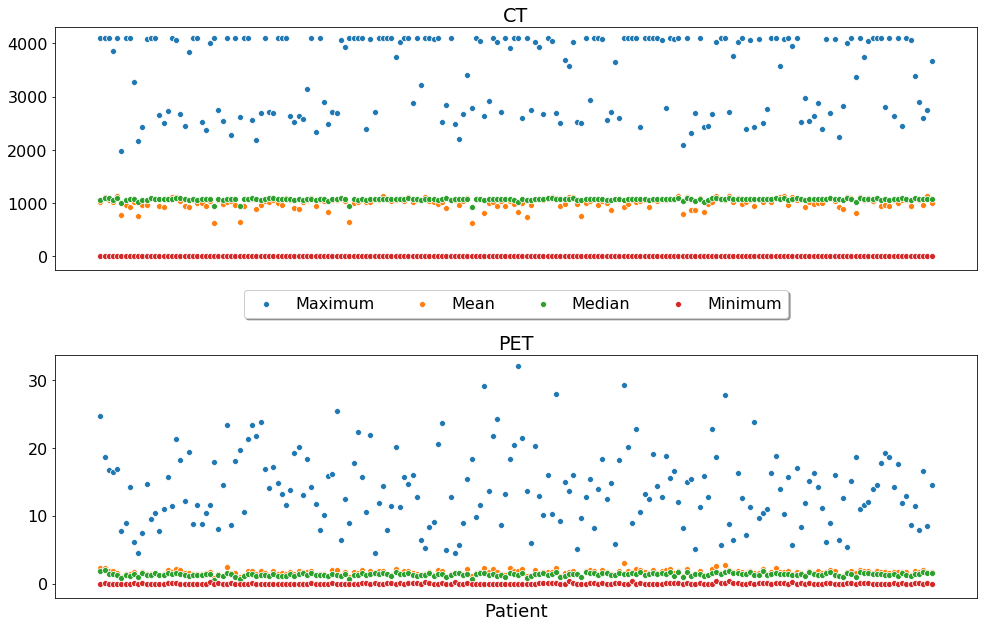

In [218]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 9))

axes[0].set_title('CT')
for row_label in df_ct_stats.T:
    sns.scatterplot(
        x=np.squeeze(df_ct_stats.columns.values), 
        y=np.squeeze(df_ct_stats.loc[row_label, :].values),
        ax=axes[0],
    )
axes[0].legend(
    ['Maximum', 'Mean', 'Median', 'Minimum'], 
    loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5
)
for row_label in df_pet_stats.T:
    sns.scatterplot(
        x=np.squeeze(df_pet_stats.columns.values), 
        y=np.squeeze(df_pet_stats.loc[row_label, :].values),
        ax=axes[1]
    )
axes[1].set_title('PET')
plt.xlabel('Patient', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.savefig(
    './../../../figures/image_sample_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=400, 
)

In [221]:
# Variations in image max values.
np.std(df_ct_stats.loc['max', :].values), np.std(df_pet_stats.loc['max', :].values)

(724.8106617375738, 5.4682313215550495)

In [223]:
# Average gray level range.
ct_avg_range = np.mean(df_ct_stats.loc['max', :].values) df_ct_stats.loc['min', :].values)
pet_avg_range = np.mean(df_pet_stats.loc['max', :].values - df_pet_stats.loc['min', :].values)
ct_avg_range, pet_avg_range

(3441.2146785663913, 13.946080060115923)